<a href="https://colab.research.google.com/github/trungtrinh44/ibnn/blob/bnn/toy_bnn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
from ibnn.models import StoLayer, BayesianLinear
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MLP(nn.Module):
  def __init__(self, layer_sizes, std, n_components=4, prior_mean=1.0, prior_std=0.3, posterior_mean_init=(1.0, 0.5), posterior_std_init=(0.05, 0.02)):
    super(MLP, self).__init__()
    self.n_components = n_components
    layers = [
        BayesianLinear(1, layer_sizes[0], prior_mean=prior_mean, prior_std=prior_std)
    ]
    for isz, osz in zip(layer_sizes[:-1], layer_sizes[1:]):
      layers.extend([
          nn.ReLU(inplace=True),
          BayesianLinear(isz, osz, prior_mean=prior_mean, prior_std=prior_std)
      ])
    self.layers = nn.ModuleList(layers)
    self.std = std
    self.sto_modules = [
      m for m in self.modules() if isinstance(m, BayesianLinear)
    ]

  def forward(self, x, L=1):
    outs = []
    for _ in range(L):
      out = x
      for layer in self.layers:
        out = layer(out)
      out = out.view(-1, 1)
      outs.append(out)
    return torch.cat(outs, dim=1)
  
  def kl(self):
    return sum(m.kl() for m in self.sto_modules)

  def vb_loss(self, x, y, n_sample):
    y = y.unsqueeze(1).expand(-1, n_sample)
    logp = D.Normal(self.forward(x, n_sample), self.std).log_prob(y).mean()
    return -logp, self.kl()
  
  def nll(self, x, y, n_sample):
    mean = self.forward(x, n_sample)
    logp = D.Normal(mean, self.std).log_prob(y.unsqueeze(1).expand(-1, self.n_components*n_sample))
    logp = torch.logsumexp(logp, 1) - torch.log(torch.tensor(self.n_components*n_sample, dtype=torch.float32, device=x.device))
    return -logp.mean(), prob

In [3]:
def generate_data():
  train_x = torch.cat([torch.arange(-3, -1.0, 0.01), torch.arange(1, 3, 0.01)])
  train_y = train_x**3 + torch.randn_like(train_x)
  test_x = torch.cat([torch.arange(-5, -3, 0.1), torch.arange(-1, 1, 0.1), torch.arange(3, 5, 0.1)])
  test_y = test_x**3 + torch.randn_like(test_x)
  return train_x, train_y, test_x, test_y

In [4]:
train_x, train_y, test_x, test_y = generate_data()

In [5]:
n_layers = 5
model = MLP([256]*n_layers + [1], 1.0, 8, 0.0, 3.0)

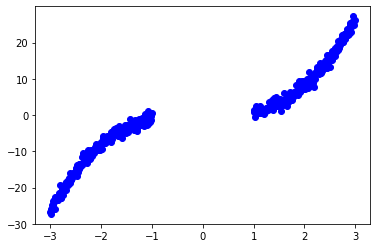

In [6]:
plt.plot(train_x, train_y, 'bo')
# plt.plot(test_x, test_y, 'ro')
plt.show()

In [7]:
# detpar = []
# stopar = []
# for name, param in model.named_parameters():
#   if 'posterior_mean' in name or 'posterior_std' in name:
#     stopar.append(param)
#   else:
#     detpar.append(param)
optimizer = torch.optim.Adam(
  model.parameters(), lr=1e-3 #, momentum=0.9, nesterov=True
)

In [8]:
model.to('cuda')
train_xi = train_x.unsqueeze(1).to('cuda')
train_yi = train_y.to('cuda')
kl_weight = 0.0
kl_max = 1.0
for _ in range(5000):
  loglike, kl = model.vb_loss(train_xi, train_yi, 10)
  loss = loglike + kl_weight*kl/len(train_xi)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  kl_weight = min(kl_max,  kl_weight + kl_max/1000.0)
  print(f"Loglike: {loglike.item():.4f}, kl: {kl.item():.4f}, kl weight: {kl_weight:.4f}", end='\n')

Streaming output truncated to the last 5000 lines.
Loglike: 229658.1719, kl: 477121.2500, kl weight: 0.0020
Loglike: 270685.5312, kl: 477124.0625, kl weight: 0.0030
Loglike: 171714.0469, kl: 477127.0000, kl weight: 0.0040
Loglike: 233314.3750, kl: 477130.0625, kl weight: 0.0050
Loglike: 194043.9219, kl: 477133.2812, kl weight: 0.0060
Loglike: 203451.5938, kl: 477136.4688, kl weight: 0.0070
Loglike: 214583.8438, kl: 477139.6562, kl weight: 0.0080
Loglike: 396807.1562, kl: 477142.8125, kl weight: 0.0090
Loglike: 163866.0000, kl: 477146.2500, kl weight: 0.0100
Loglike: 396866.0625, kl: 477149.6562, kl weight: 0.0110
Loglike: 168433.0469, kl: 477153.2812, kl weight: 0.0120
Loglike: 74433.2969, kl: 477156.8750, kl weight: 0.0130
Loglike: 102718.1172, kl: 477160.2188, kl weight: 0.0140
Loglike: 226016.3281, kl: 477163.4688, kl weight: 0.0150
Loglike: 179417.8438, kl: 477166.7500, kl weight: 0.0160
Loglike: 143174.0312, kl: 477170.0625, kl weight: 0.0170
Loglike: 112239.4844, kl: 477173.3125,

In [9]:
test_y = model.forward(torch.arange(-5, 5, 0.05, device='cuda').unsqueeze(1), 60)

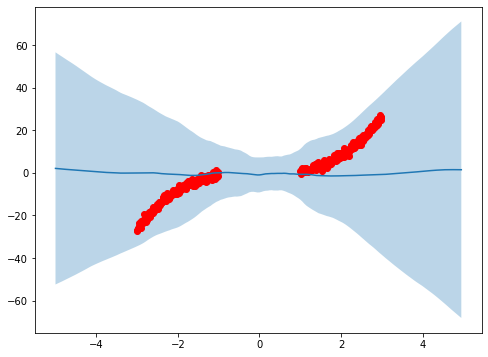

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(train_x, train_y, 'ro')
plt.plot(
    torch.arange(-5, 5, 0.05).numpy(), 
    test_y.mean(1).cpu().detach().numpy()
)
plt.fill_between(
    torch.arange(-5, 5, 0.05).numpy(),
    test_y.mean(1).cpu().detach().numpy() - 2*test_y.std(1).cpu().detach().numpy(),
    test_y.mean(1).cpu().detach().numpy() + 2*test_y.std(1).cpu().detach().numpy(), alpha=0.3
)
plt.savefig(f'bnn_{n_layers}.pdf')